<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFEpostprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**pip**
---



In [83]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

CPU times: user 2.66 s, sys: 503 ms, total: 3.16 s
Wall time: 29.2 s


**import**
---



In [0]:
import glob
import os
import pathlib as Path
from sys import getsizeof
import dask
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
from dask.distributed import Client
from shapely.geometry import box

In [0]:
%%capture
client = Client(processes=False)
client

In [86]:
%cd /content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE

/content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE


In [0]:
pathShapefile = './data/shapefile'
path_output = '../../02_output'

In [88]:
!ls '../../02_output'

ctganOutput				 smallBurnedBuildings.shp
scenario1249_pid958_Activations.parquet  smallBurnedBuildings.shx
scenario1249_pid959_Activations.parquet  smallMonteCarlo2500runs.jpg
smallBurnedBuildings.cpg		 smallMonteCarlo2500runs.parquet
smallBurnedBuildings.dbf		 smallShapeEdges.parquet
smallBurnedBuildings.prj


**definitions**
---

In [0]:
@dask.delayed
def read_and_concatenate_parquets(prefix, path=path_output):
  L = []
  files = glob.glob(os.path.join(path_output, prefix))# output_scenario_0_step_0.parquet
  for file in files:
    print("file loaded : {}".format(file))
    pqt = dd.read_parquet(file)
    L.append(pqt)
  df = dd.concat(L)
  return df

def count_fid_occurences(df):
  count = df['source'].value_counts().compute()
  count_df = pd.DataFrame({'source': count.index, 'count': count.values})
  return count_df

def load_shapefile(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(pathShapefile,file_name), bbox=bbox)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    # gdf_buildings.plot(column='IgnProb_bl', cmap='hsv', legend=True)
    return gdf_buildings

def merge_coordinates_export_shape(ddf, gdf, name_output):
  gdf = gdf[['TARGET_FID', 'geometry']]
  df = pd.DataFrame(gdf)
  # ddf = ddf.compute()
  df_merge = ddf.merge(df, how='left', left_on='source', right_on='TARGET_FID')
  gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry')
  gdf_merge.to_file(os.path.join(path_output, name_output + ".shp"))

  f, ax = plt.subplots(1, figsize=(12, 12))
  countPlot = gdf_merge.plot(column='count', cmap='seismic', legend=True, ax=ax)
  plt.savefig(os.path.join(path_output, 'smallMonteCarlo2500runs.jpg'), dpi=300)
  plt.show()
  return gdf_merge

**runs**
---



In [0]:
df = read_and_concatenate_parquets("scenario*")

In [91]:
t = df.compute()
t.to_csv(os.path.join(path_output, 'smallMonteCarlo2500runs.csv'))

file loaded : ../../02_output/scenario1249_pid958_Activations.parquet
file loaded : ../../02_output/scenario1249_pid959_Activations.parquet


['/content/drive/My Drive/Colab Notebooks/02_output/smallMonteCarlo2500runs.csv/0.part',
 '/content/drive/My Drive/Colab Notebooks/02_output/smallMonteCarlo2500runs.csv/1.part']

In [92]:
count_df = count_fid_occurences(df)

file loaded : ../../02_output/scenario1249_pid958_Activations.parquet
file loaded : ../../02_output/scenario1249_pid959_Activations.parquet


In [93]:
count_df.describe()

,source
count,1606.000000
mean,46307.815068
std,19038.523407
min,201.000000
25%,28676.500000
50%,30912.500000
75%,61735.750000
max,72678.000000


Shapefile extent : [1748498.0152998  5425264.79535007 1749563.95249987 5427653.74945021]
Asset loaded : 1611


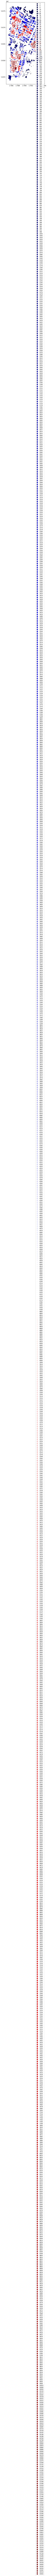

In [94]:
gdf = load_shapefile("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
gdf_count = merge_coordinates_export_shape(count_df, gdf, "smallBurnedBuildings")